#Surface of revolution noisy line elements

Using Bayesian Gaussian process latent variable model to discover a latent space representation of the line elements of a surface of revolution.

Made by Ivan De Boi (ivan.deboi at uantwerpen.be, http://www.InViLab.be).

In [1]:
shape_name_string = 'Surface of revolution noisy'

# Imports

In [2]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

import warnings
warnings.filterwarnings('ignore')

from matplotlib import cm

!pip install GPy
import GPy
from GPy.util import pca
from GPy import kern
GPy.plotting.change_plotting_library('matplotlib')

from sklearn.preprocessing import StandardScaler

import plotly.graph_objects as go

from numpy import genfromtxt

from google.colab import drive
from google.colab import files

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 959 kB 8.6 MB/s 
     |████████████████████████████████| 71 kB 7.9 MB/s 
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565114 sha256=f9e8c76a71379d0b677d1ce4724248c1d5df243a4b4897a7e4303135d4381993
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b086fd952511d088b21e8359ea496860a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102566 sha256=688c58e06c12a5940c0c6500c48e6efa8278720531c44be66a3c654952cc52fa
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built GPy paramz


In [3]:
#use this to adjust the resolution of the pictures etc.
#print(plt.rcParams)  # it will tell you all default setting in Matplotlib
print(plt.rcParams.get('figure.figsize'))
plt.rcParams['figure.figsize'] = [8,6]
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('figure.dpi'))
plt.rcParams['figure.dpi'] = 72.0*5
print(plt.rcParams.get('figure.dpi'))

[6.0, 4.0]
[8.0, 6.0]
72.0
360.0


# Data

In [4]:
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/PhD 3D Sensing/05 GPLVM on set of lines/Line Elements Surface/Line Elements/'  #change dir to your project folder

Mounted at /content/gdrive


In [5]:
data = genfromtxt(root_path + shape_name_string + ' line elements.csv', delimiter=',')
shape_name_string
Y = data[:,:]
print(Y[0:3,:])
print(Y.shape)

[[ 0.98051596  0.19532597 -0.02088875 -0.01858488  0.00755558 -0.80172181
  -0.90535396]
 [ 0.98395807  0.17705117  0.02189547  0.00270746  0.08172632 -0.7825259
  -0.91855204]
 [ 0.99277693  0.11369396  0.03830763  0.01561774  0.09615605 -0.69013113
  -0.96444654]]
(14208, 7)


# PCA

In [6]:
# Normalize
scaler = StandardScaler()
scaler.fit(Y)

Yn = scaler.transform(Y)
print(Yn[0:3, :])

# Sanity checks
print("mean y:",Y.mean())
print("std y:", Y.std())
print("mean yn:", Yn.mean())
print("std yn:", Yn.std())

[[ 1.83736039  0.3607417  -0.03835164 -0.41734808  0.01916348 -2.04961068
  -2.25707663]
 [ 1.84289719  0.32702225  0.04060386  0.06076832  0.20861987 -2.00051966
  -2.27974479]
 [ 1.85708276  0.21011974  0.07089144  0.35066673  0.24547812 -1.76423224
  -2.35857021]]
mean y: 0.035220966497107584
std y: 0.5078755864390098
mean yn: 1.0716438461632785e-17
std yn: 0.9999999999999998


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

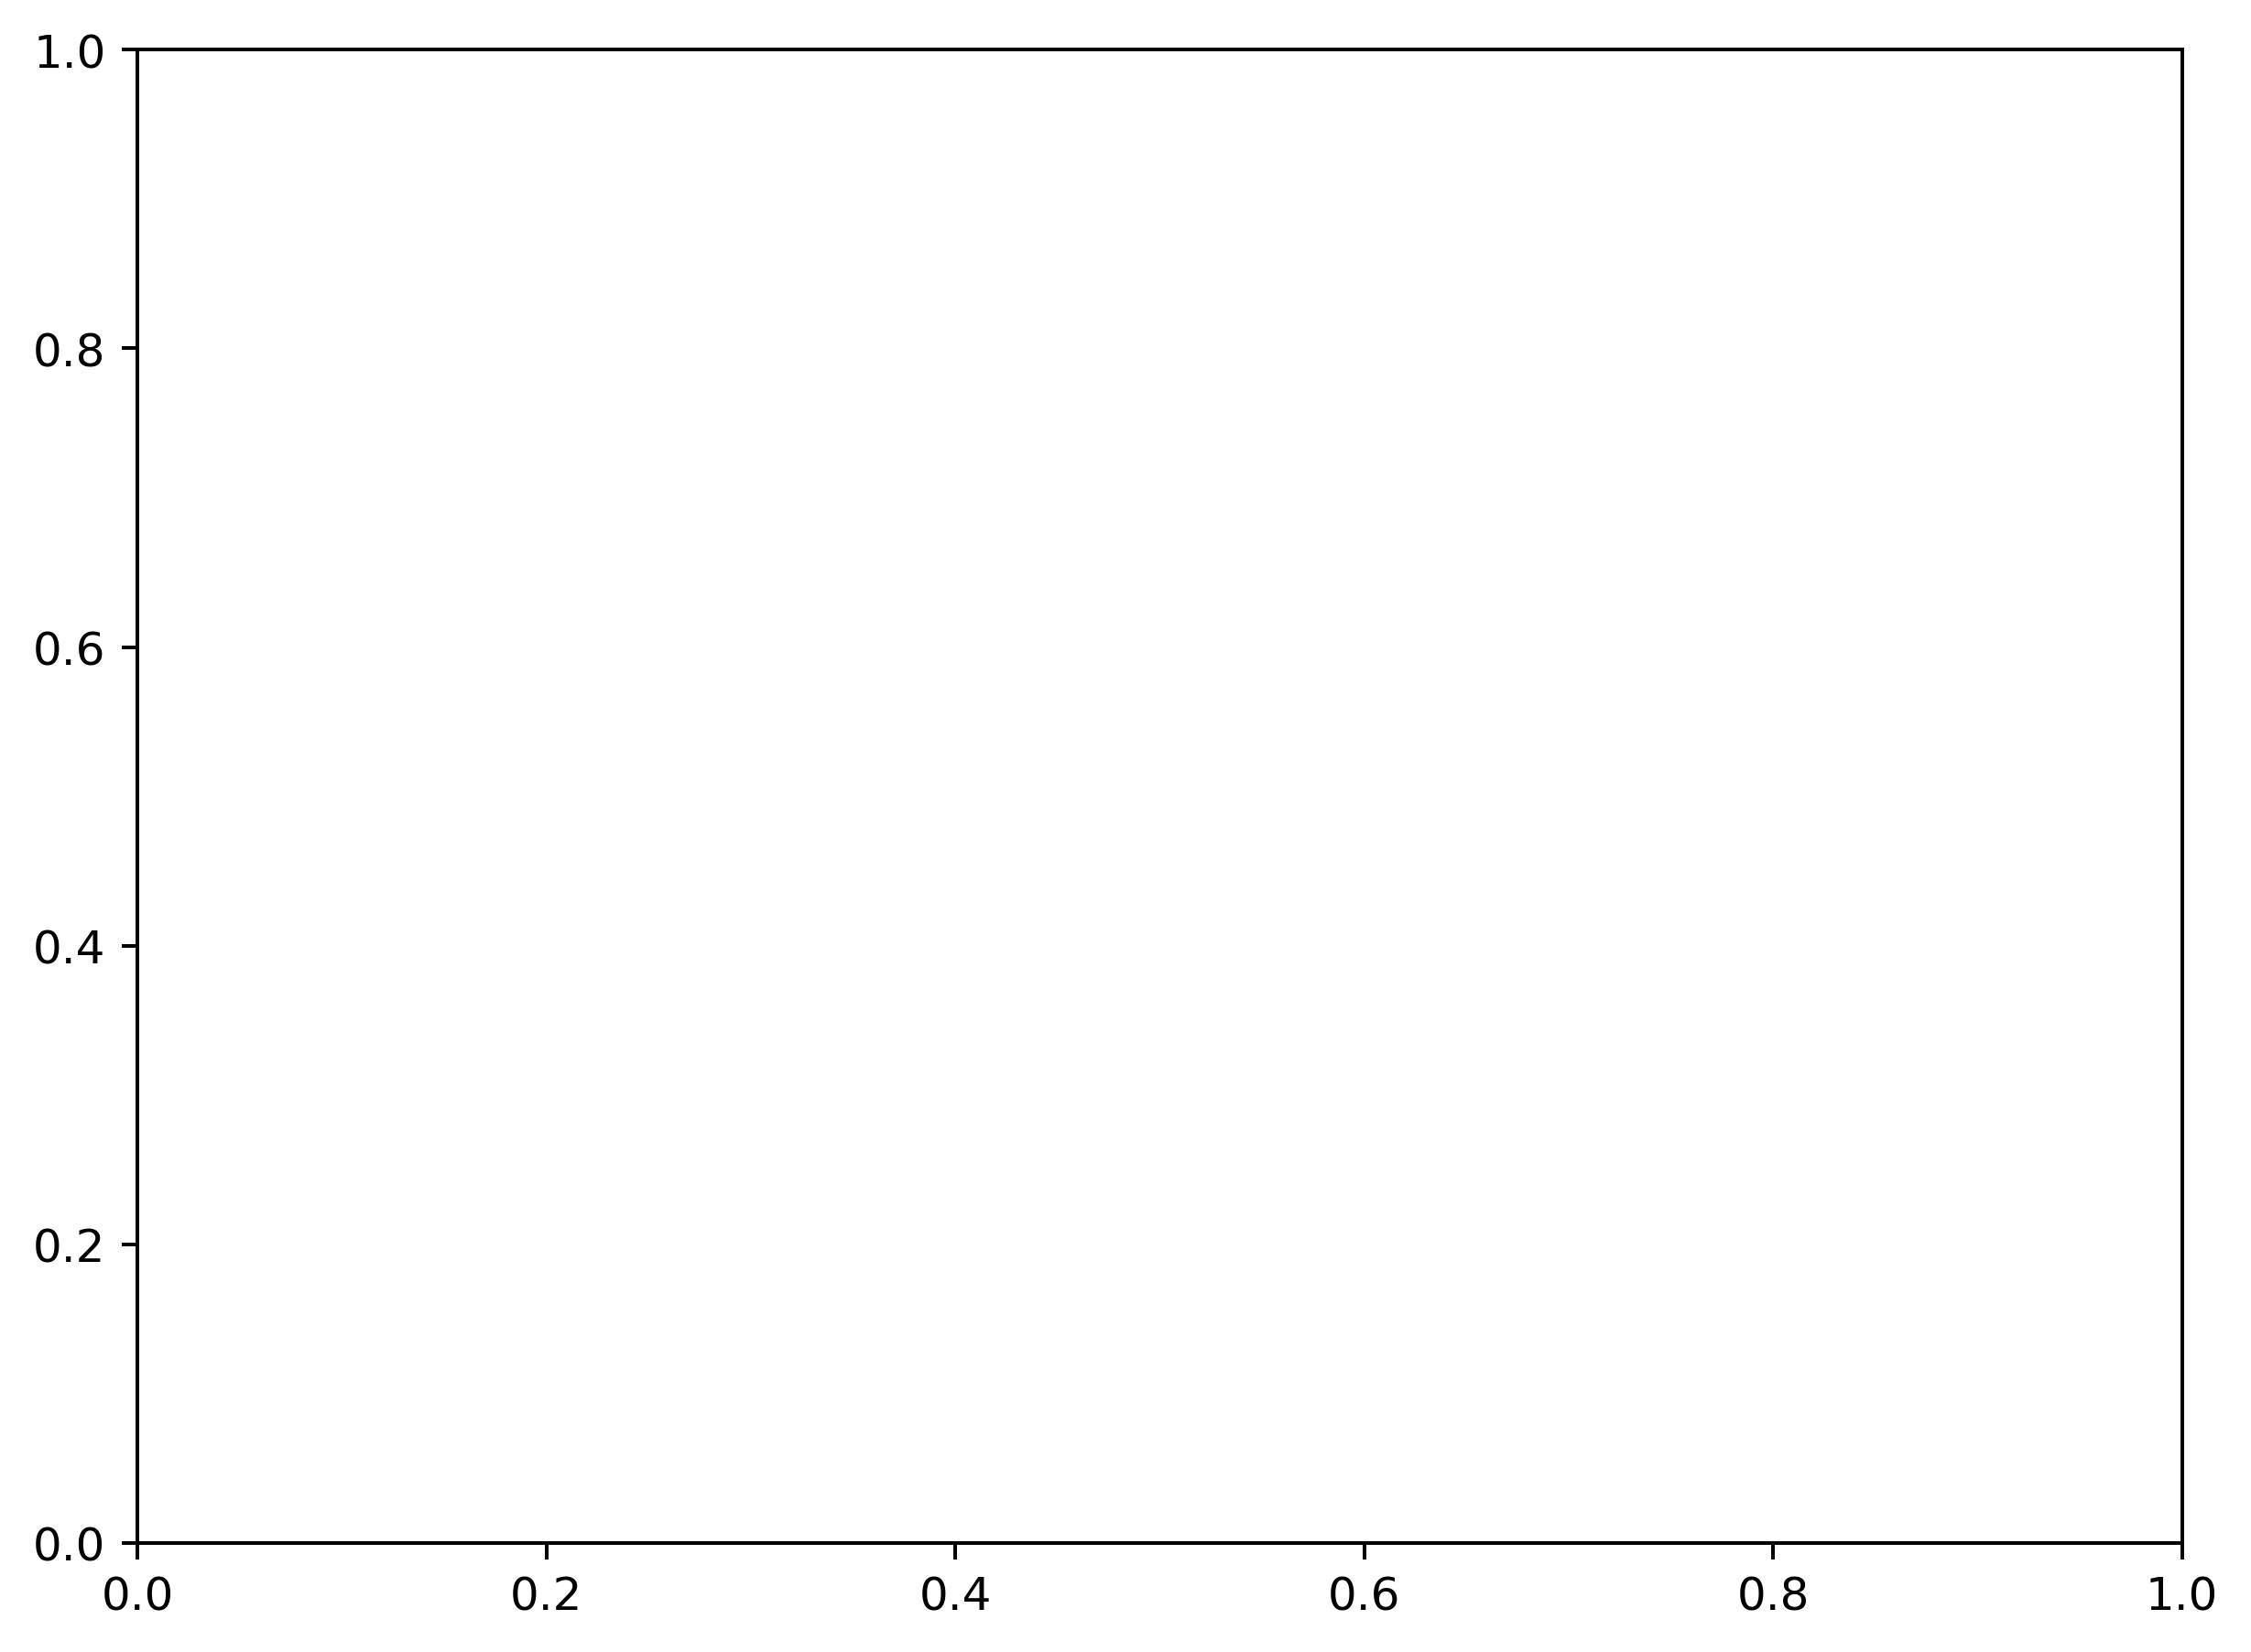

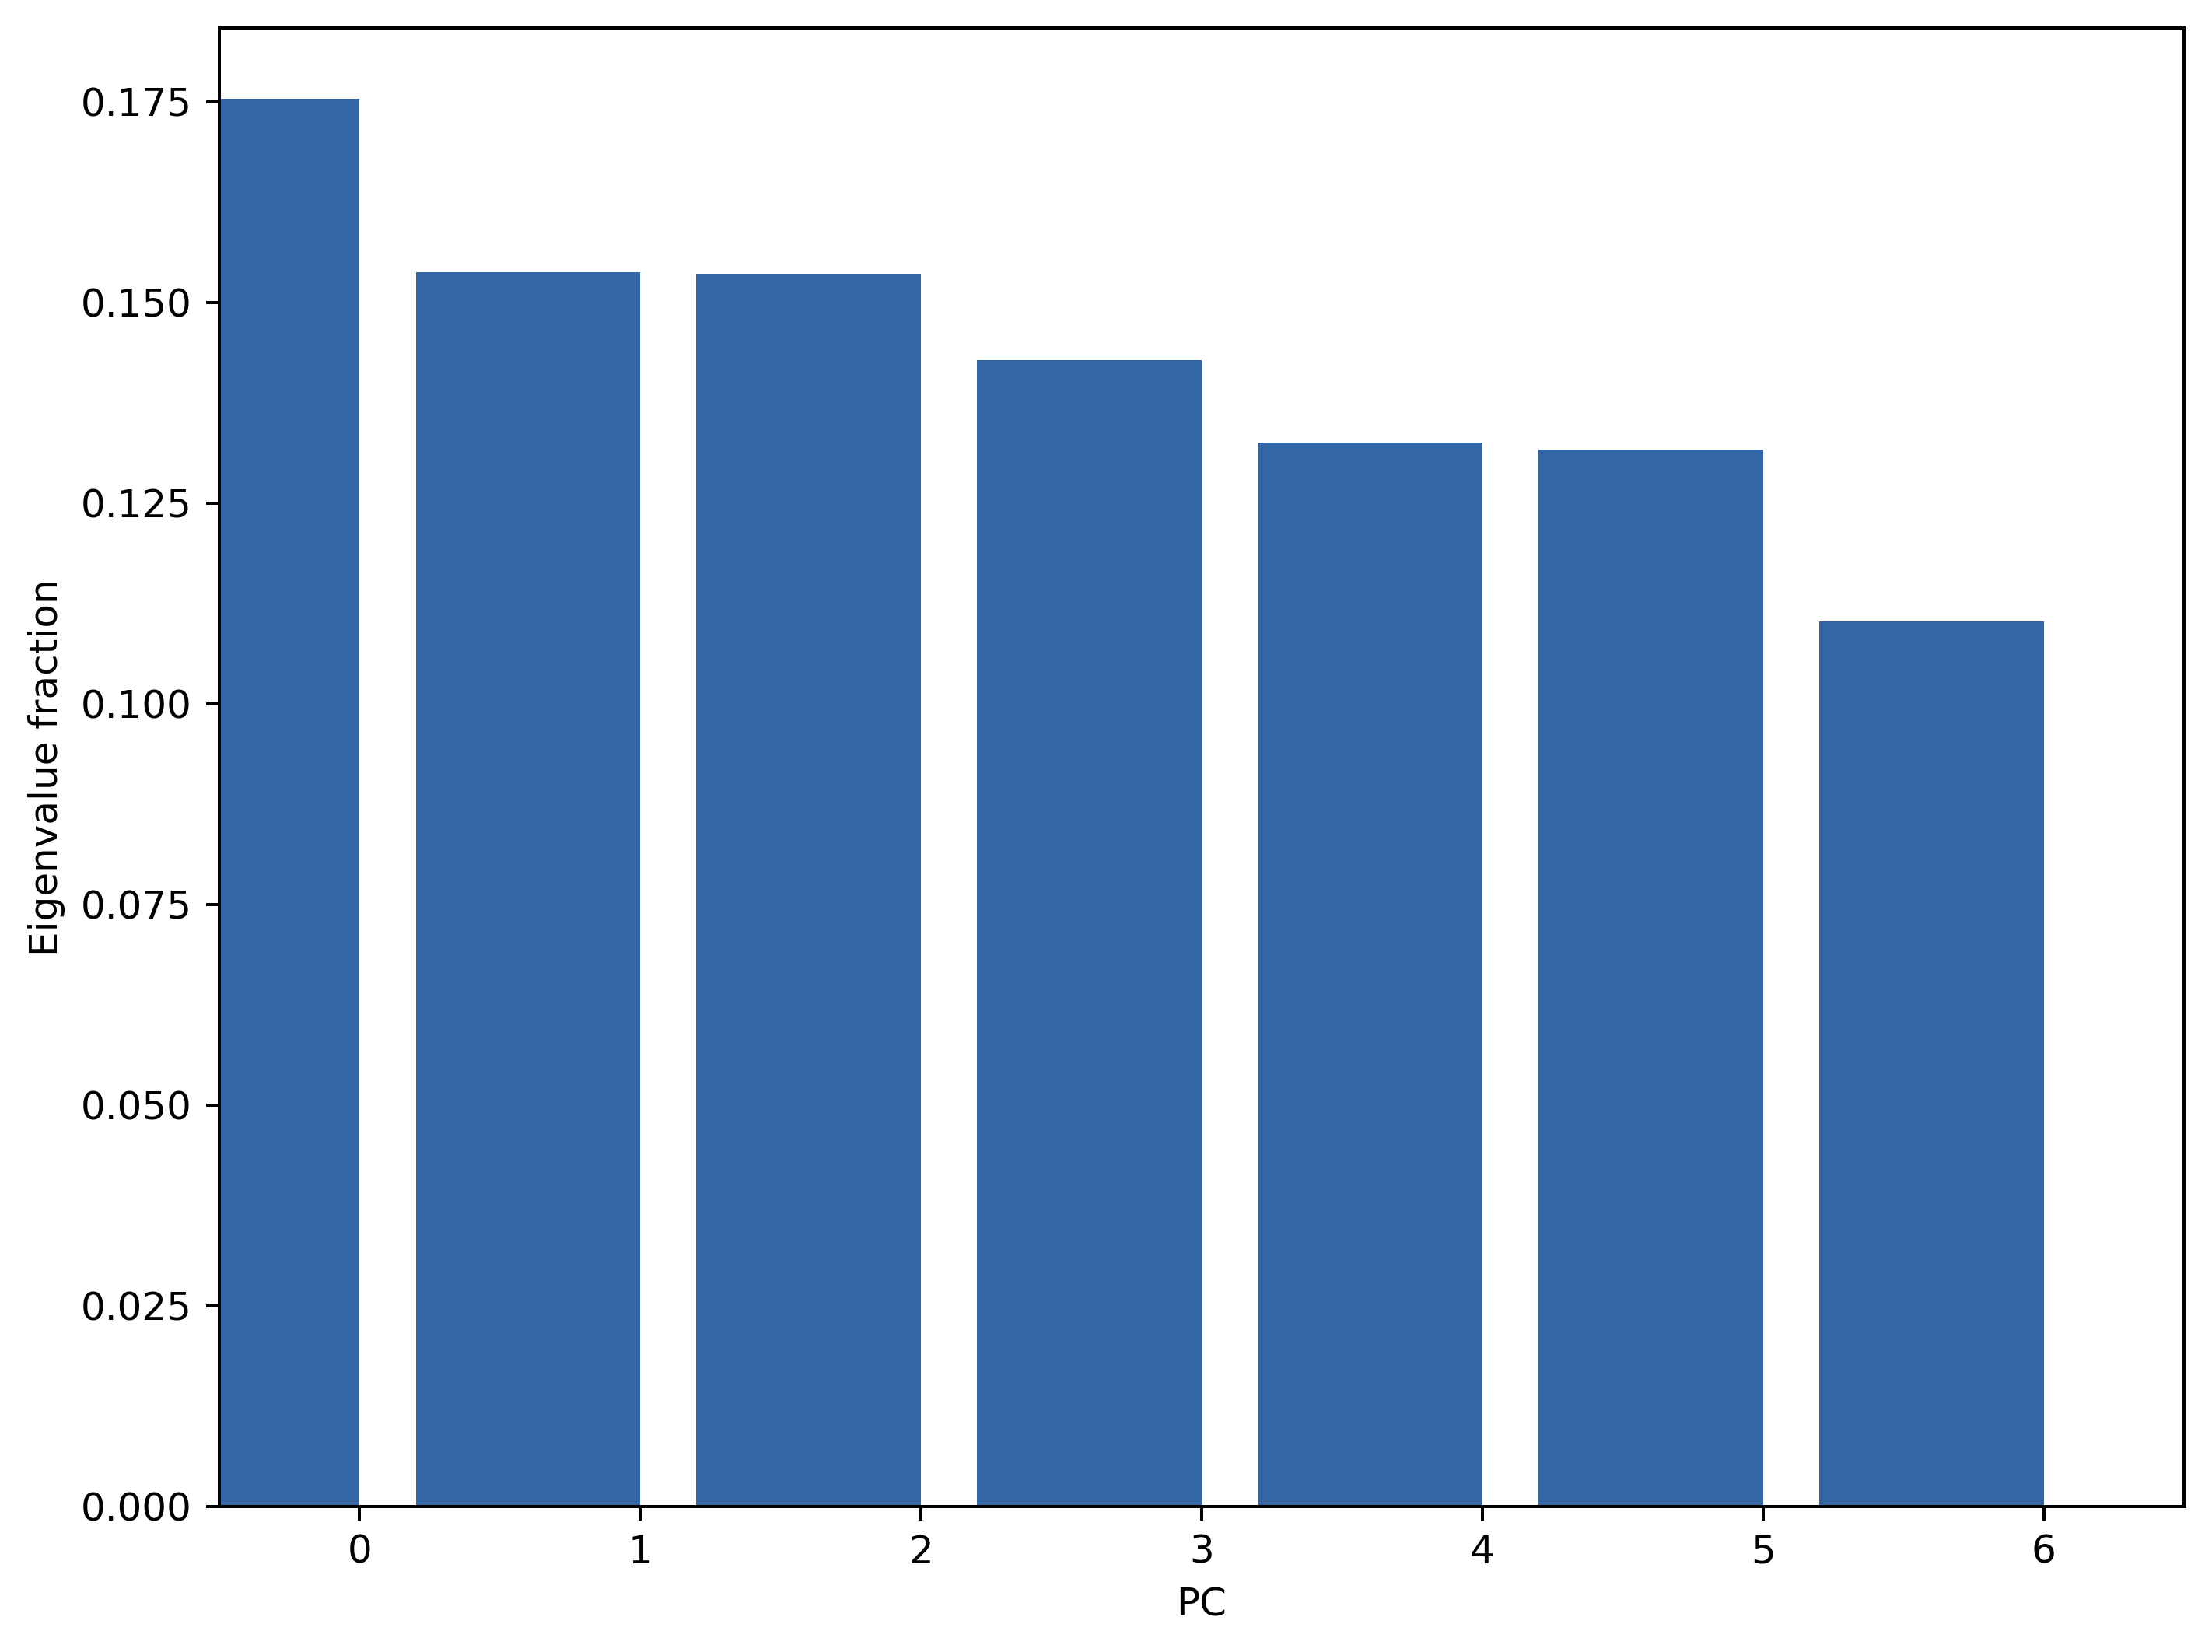

In [7]:
p = pca.PCA(Yn)
# plot first xxx eigenvalue fractions

fig, ax = plt.subplots()
p.plot_fracs(Yn.shape[1]) 

filename = shape_name_string + ' PCA.png'
plt.savefig(filename)
files.download('/content/' + filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

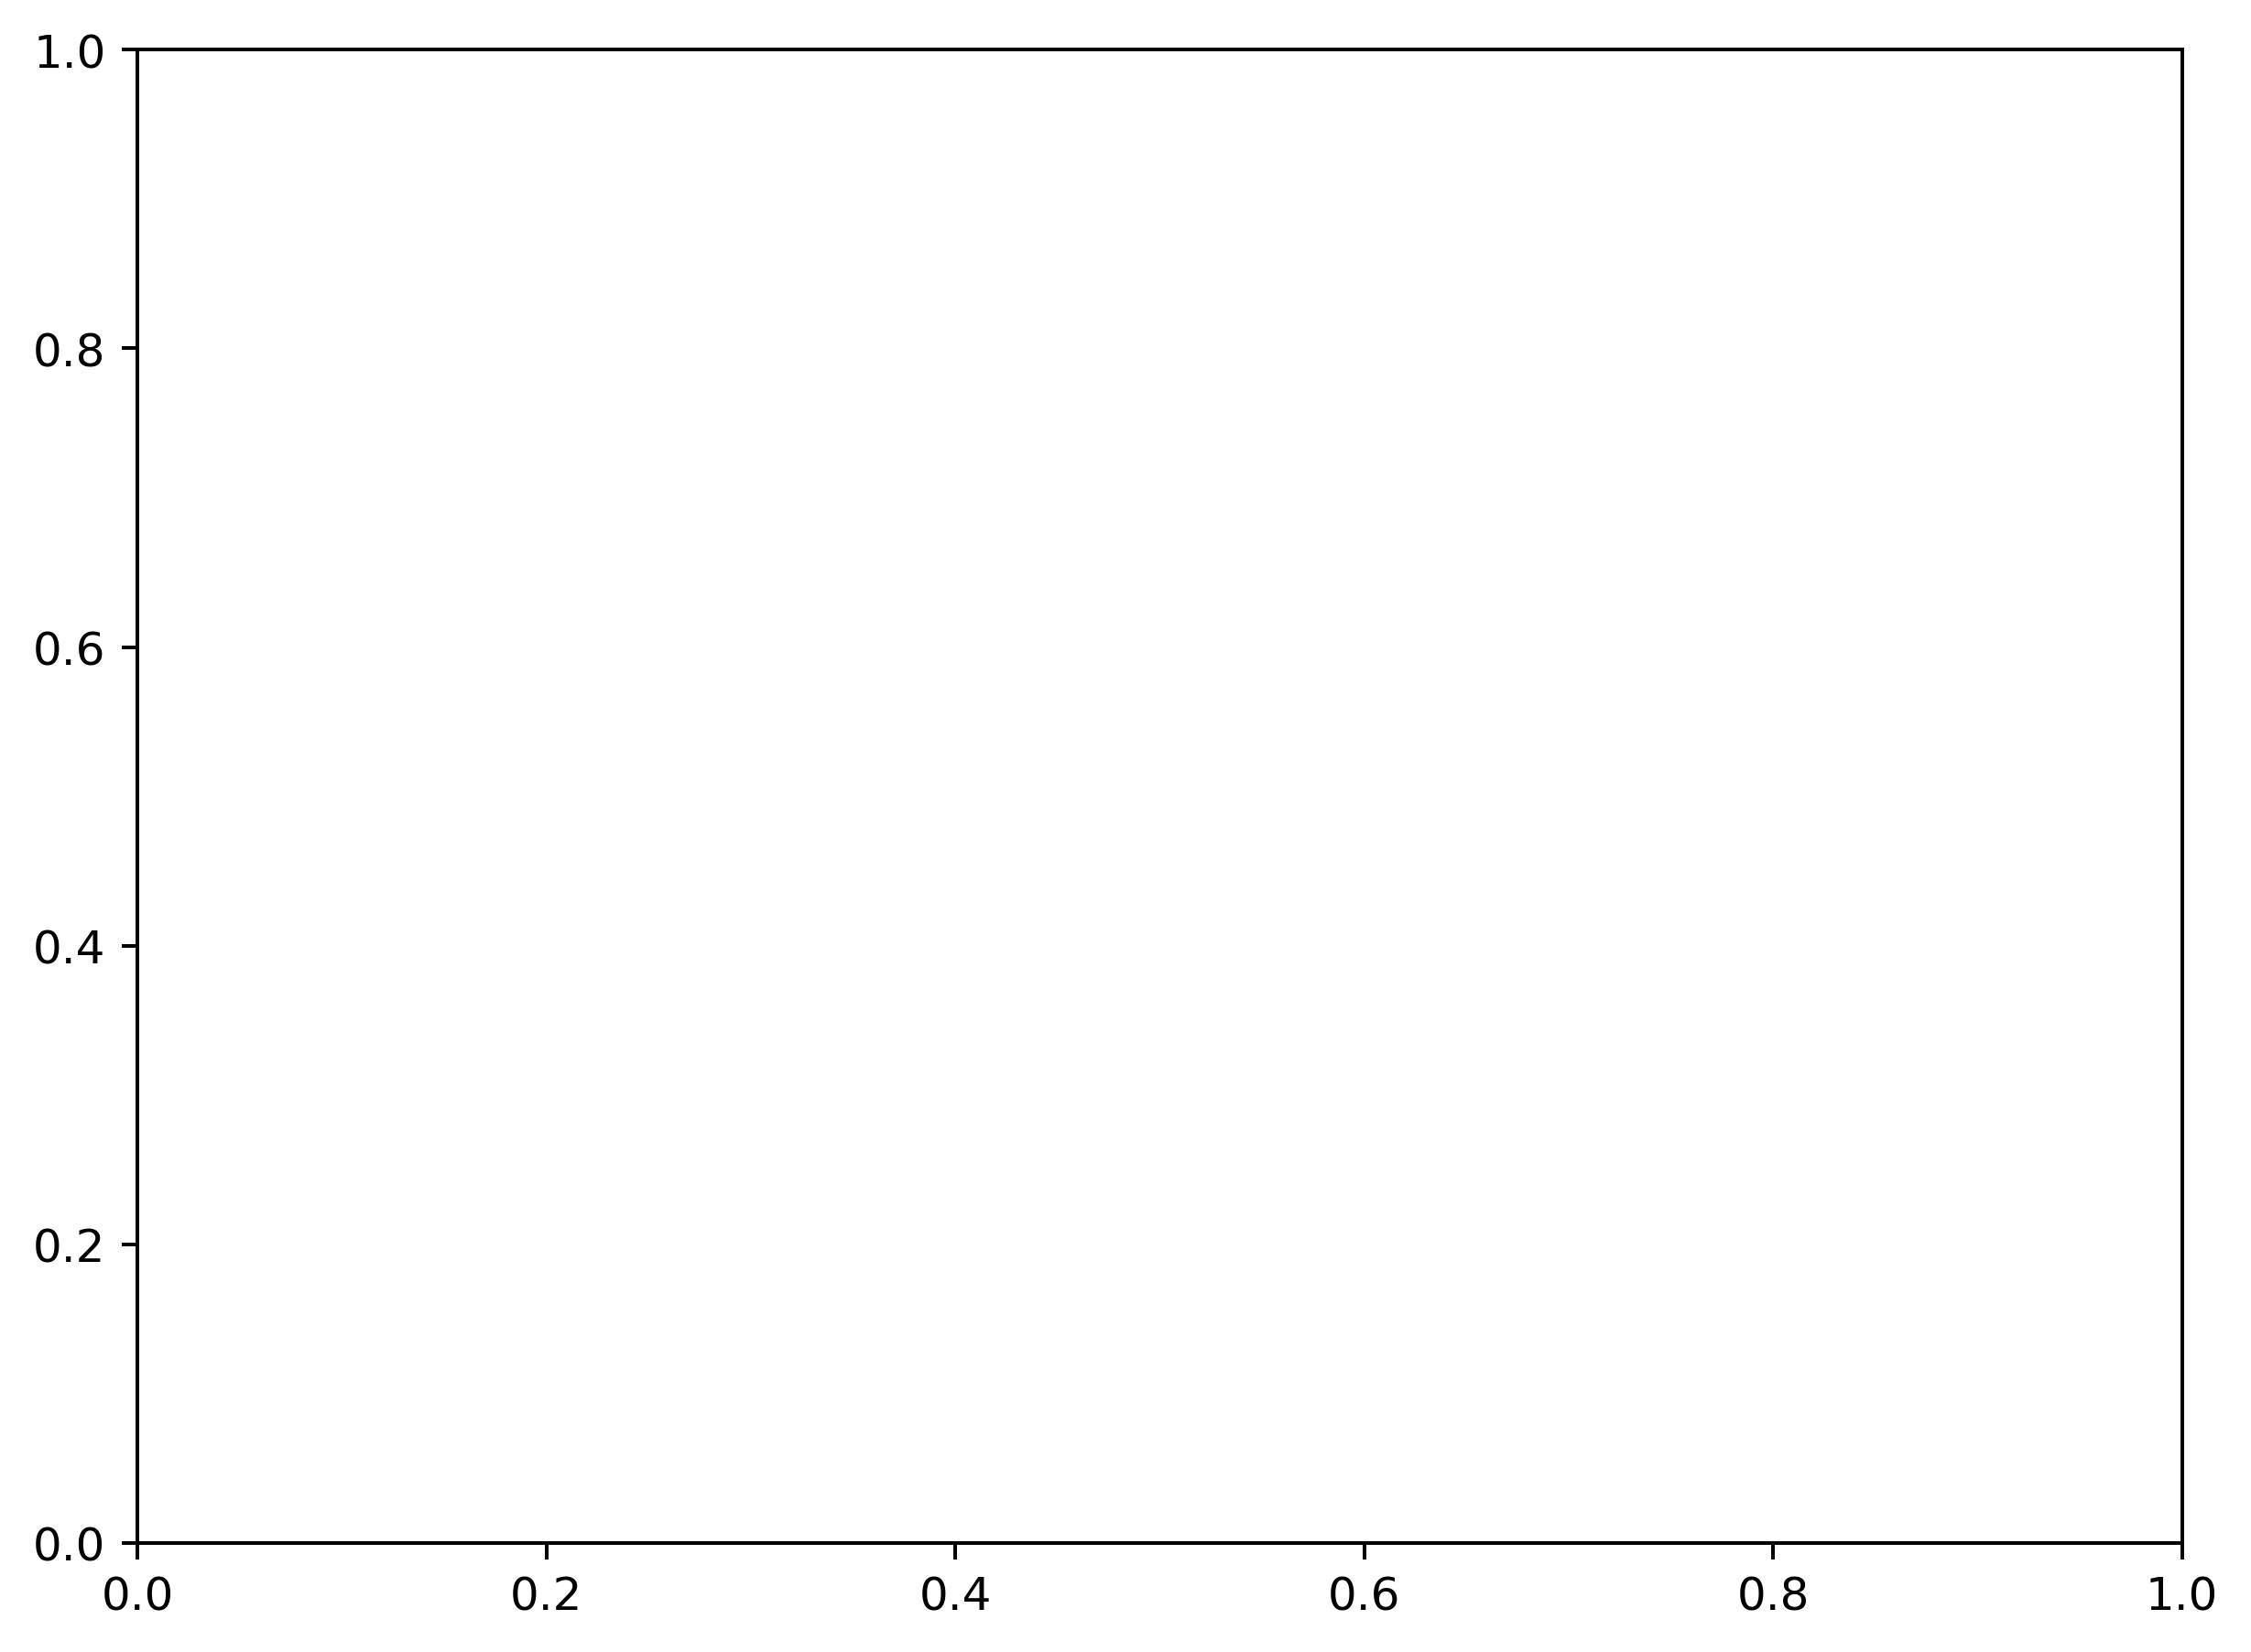

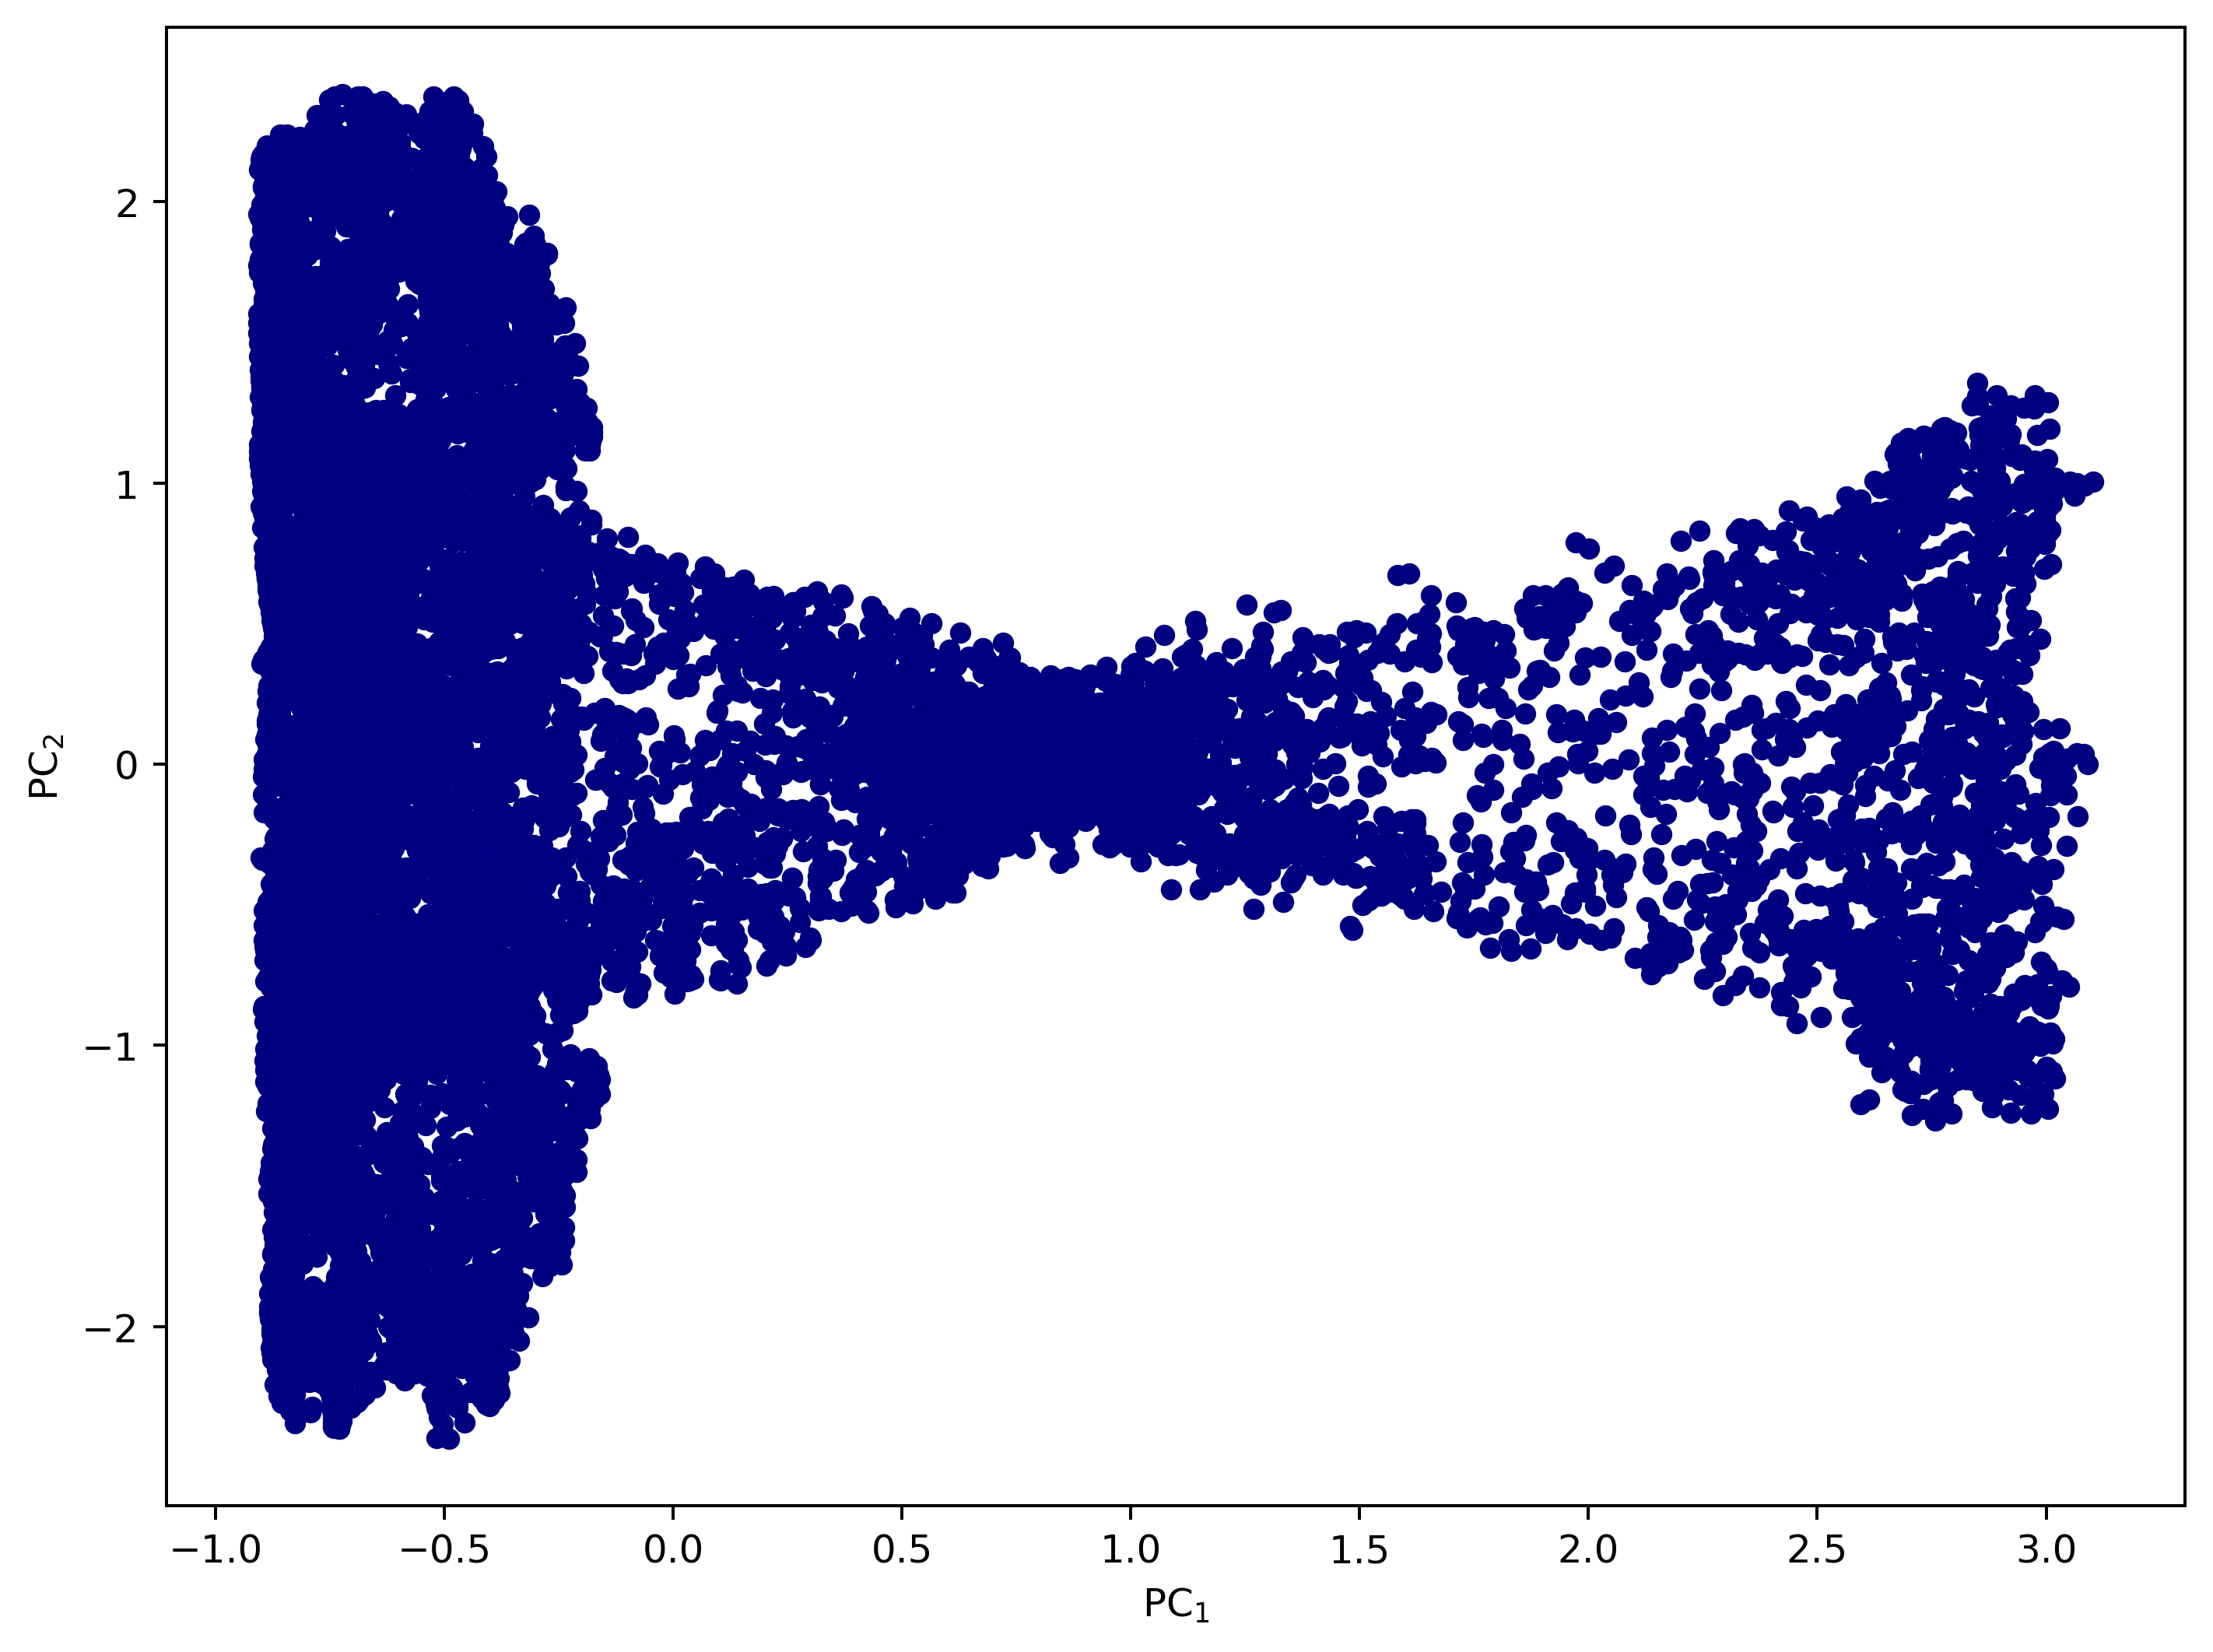

In [8]:
# plot the latent space by PCA

fig, ax = plt.subplots()
p.plot_2d(Yn)

filename = shape_name_string + ' 2D PCA.png'
plt.savefig(filename)
files.download('/content/' + filename)

# BGPLVM

In [9]:
max_nr_of_data_points = 2500 #use this line to subsample
#max_nr_of_data_points = Y.shape[0]
Y = Y[np.random.choice(Y.shape[0], max_nr_of_data_points, replace=False), :] #permutation on the datapoints
print(Y.shape)

points = np.zeros((Y.shape[0], 3))
for i in range(Y.shape[0]):
  p = np.cross(Y[i,0:3], Y[i,3:6]) + Y[i,6]*Y[i,0:3] #calculate the points from the line elements
  points[i,:] = p
print(points.shape)


plt.style.use('seaborn-poster')
ax = plt.axes(projection='3d')

ax.scatter3D(points[:, 0], points[:,1], points[:, 2], c = points[:, 2])
ax.set_title('Points in training')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

filename = shape_name_string + ' points in training.png'
plt.savefig(filename)
files.download('/content/' + filename)

plt.show(ax)

Output hidden; open in https://colab.research.google.com to view.

In [10]:
max_nr_of_iters = 20000

init='PCA'
#init='random'

likelihood_variance = 1e-6
likelihood_variance_fix = False #use this to fix the noiselevel

optimizer = 'scg'
optimizer = 'lbfgs'
#optimizer = 'tnc'

num_restarts = 10

input_dim = 7 #Y.shape[1]
num_inducing = 50

In [11]:
k_GPLVM = GPy.kern.RBF(input_dim, ARD = True)

m_GPLVM = GPy.models.BayesianGPLVM(Y, input_dim, kernel=k_GPLVM, init=init, num_inducing=num_inducing)

if likelihood_variance_fix:
  m_GPLVM.likelihood.variance = likelihood_variance
  m_GPLVM.likelihood.variance.fix()

m_GPLVM.optimize_restarts(messages=1, num_restarts=num_restarts, max_iters=max_nr_of_iters, optimizer = optimizer) 
print(m_GPLVM) 

Optimization restart 1/10, f = -4431.330879319365


Optimization restart 2/10, f = 12940.948766616817


Optimization restart 3/10, f = 12940.956417766083


Optimization restart 4/10, f = 12940.954626021148


Optimization restart 5/10, f = 12940.963037350528


Optimization restart 6/10, f = 12940.94833262458


Optimization restart 7/10, f = 12940.96464293358


Optimization restart 8/10, f = 12940.954671410465


Optimization restart 9/10, f = 12940.948452115521


Optimization restart 10/10, f = 11931.729458515098

Name : bayesian gplvm
Objective : -4431.330879319365
Number of Parameters : 35359
Number of Optimization Parameters : 35359
Updates : True
Parameters:
  bayesian_gplvm.          |                  value  |  constraints  |  priors
  latent_space.mean        |              (2500, 7)  |               |        
  latent_space.variance    |              (2500, 7)  |      +ve      |        
  inducing_inputs          |                (50, 7)  |               |        
  rbf.variance             |      3.141080034743479  |      +ve      |        
  rbf.lengthscale          |                   (7,)  |      +ve      |        
  Gaussian_noise.variance  |  0.0009713400545138748  |      +ve      |        


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

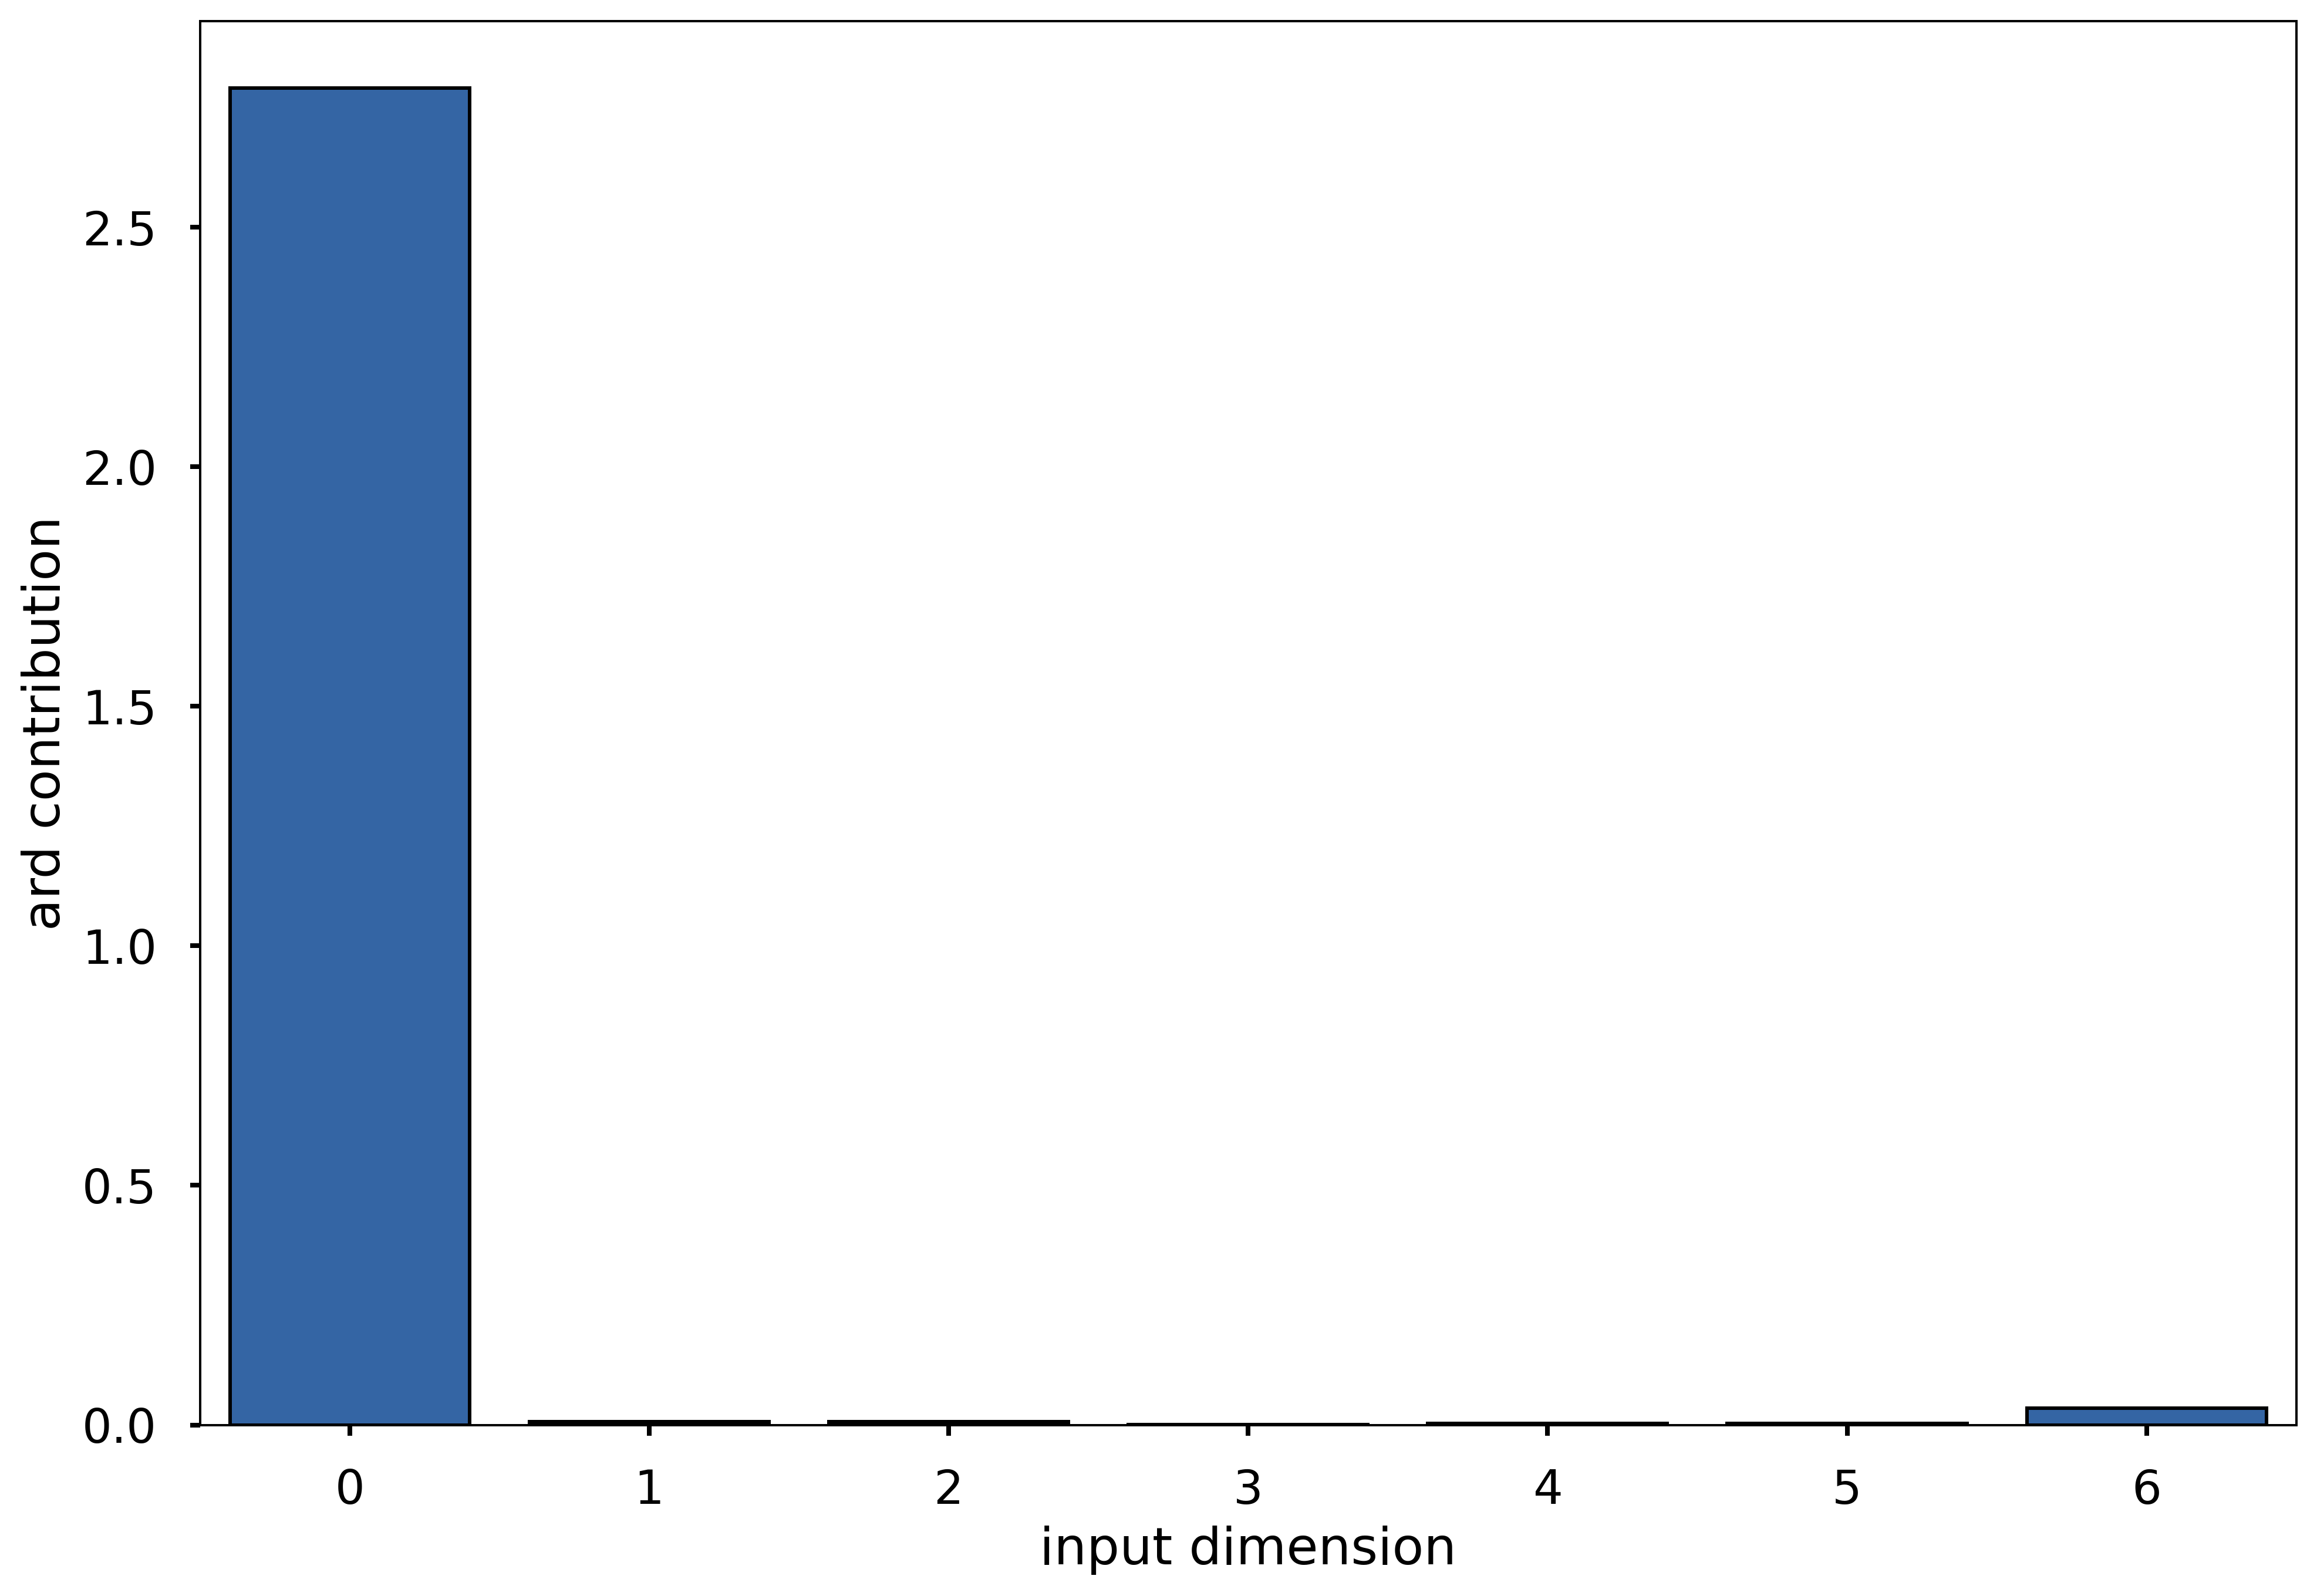

In [12]:
fig, ax = plt.subplots()
m_GPLVM.kern.plot_ARD(ax=ax)

filename = shape_name_string + ' ARD.png'
plt.savefig(filename)
files.download('/content/' + filename)

In [13]:
m_GPLVM.kern.lengthscale #which is the inverse of ARD contribution

index,bayesian_gplvm.rbf.lengthscale,constraints,priors
[0],1.06085054,+ve,
[1],21.95330660,+ve,
[2],21.70136545,+ve,
[3],99.28766128,+ve,
[4],33.29924591,+ve,
[5],33.98907020,+ve,
[6],9.43639850,+ve,


In [14]:
lengthscales = m_GPLVM.kern.lengthscale.argsort()
input_dimension_1 =lengthscales[0]
input_dimension_2 =lengthscales[1]
input_dimension_3 =lengthscales[2]

print(input_dimension_1)
print(input_dimension_2)
print(input_dimension_3)

0
6
2


In [15]:
latent = m_GPLVM.X.mean 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

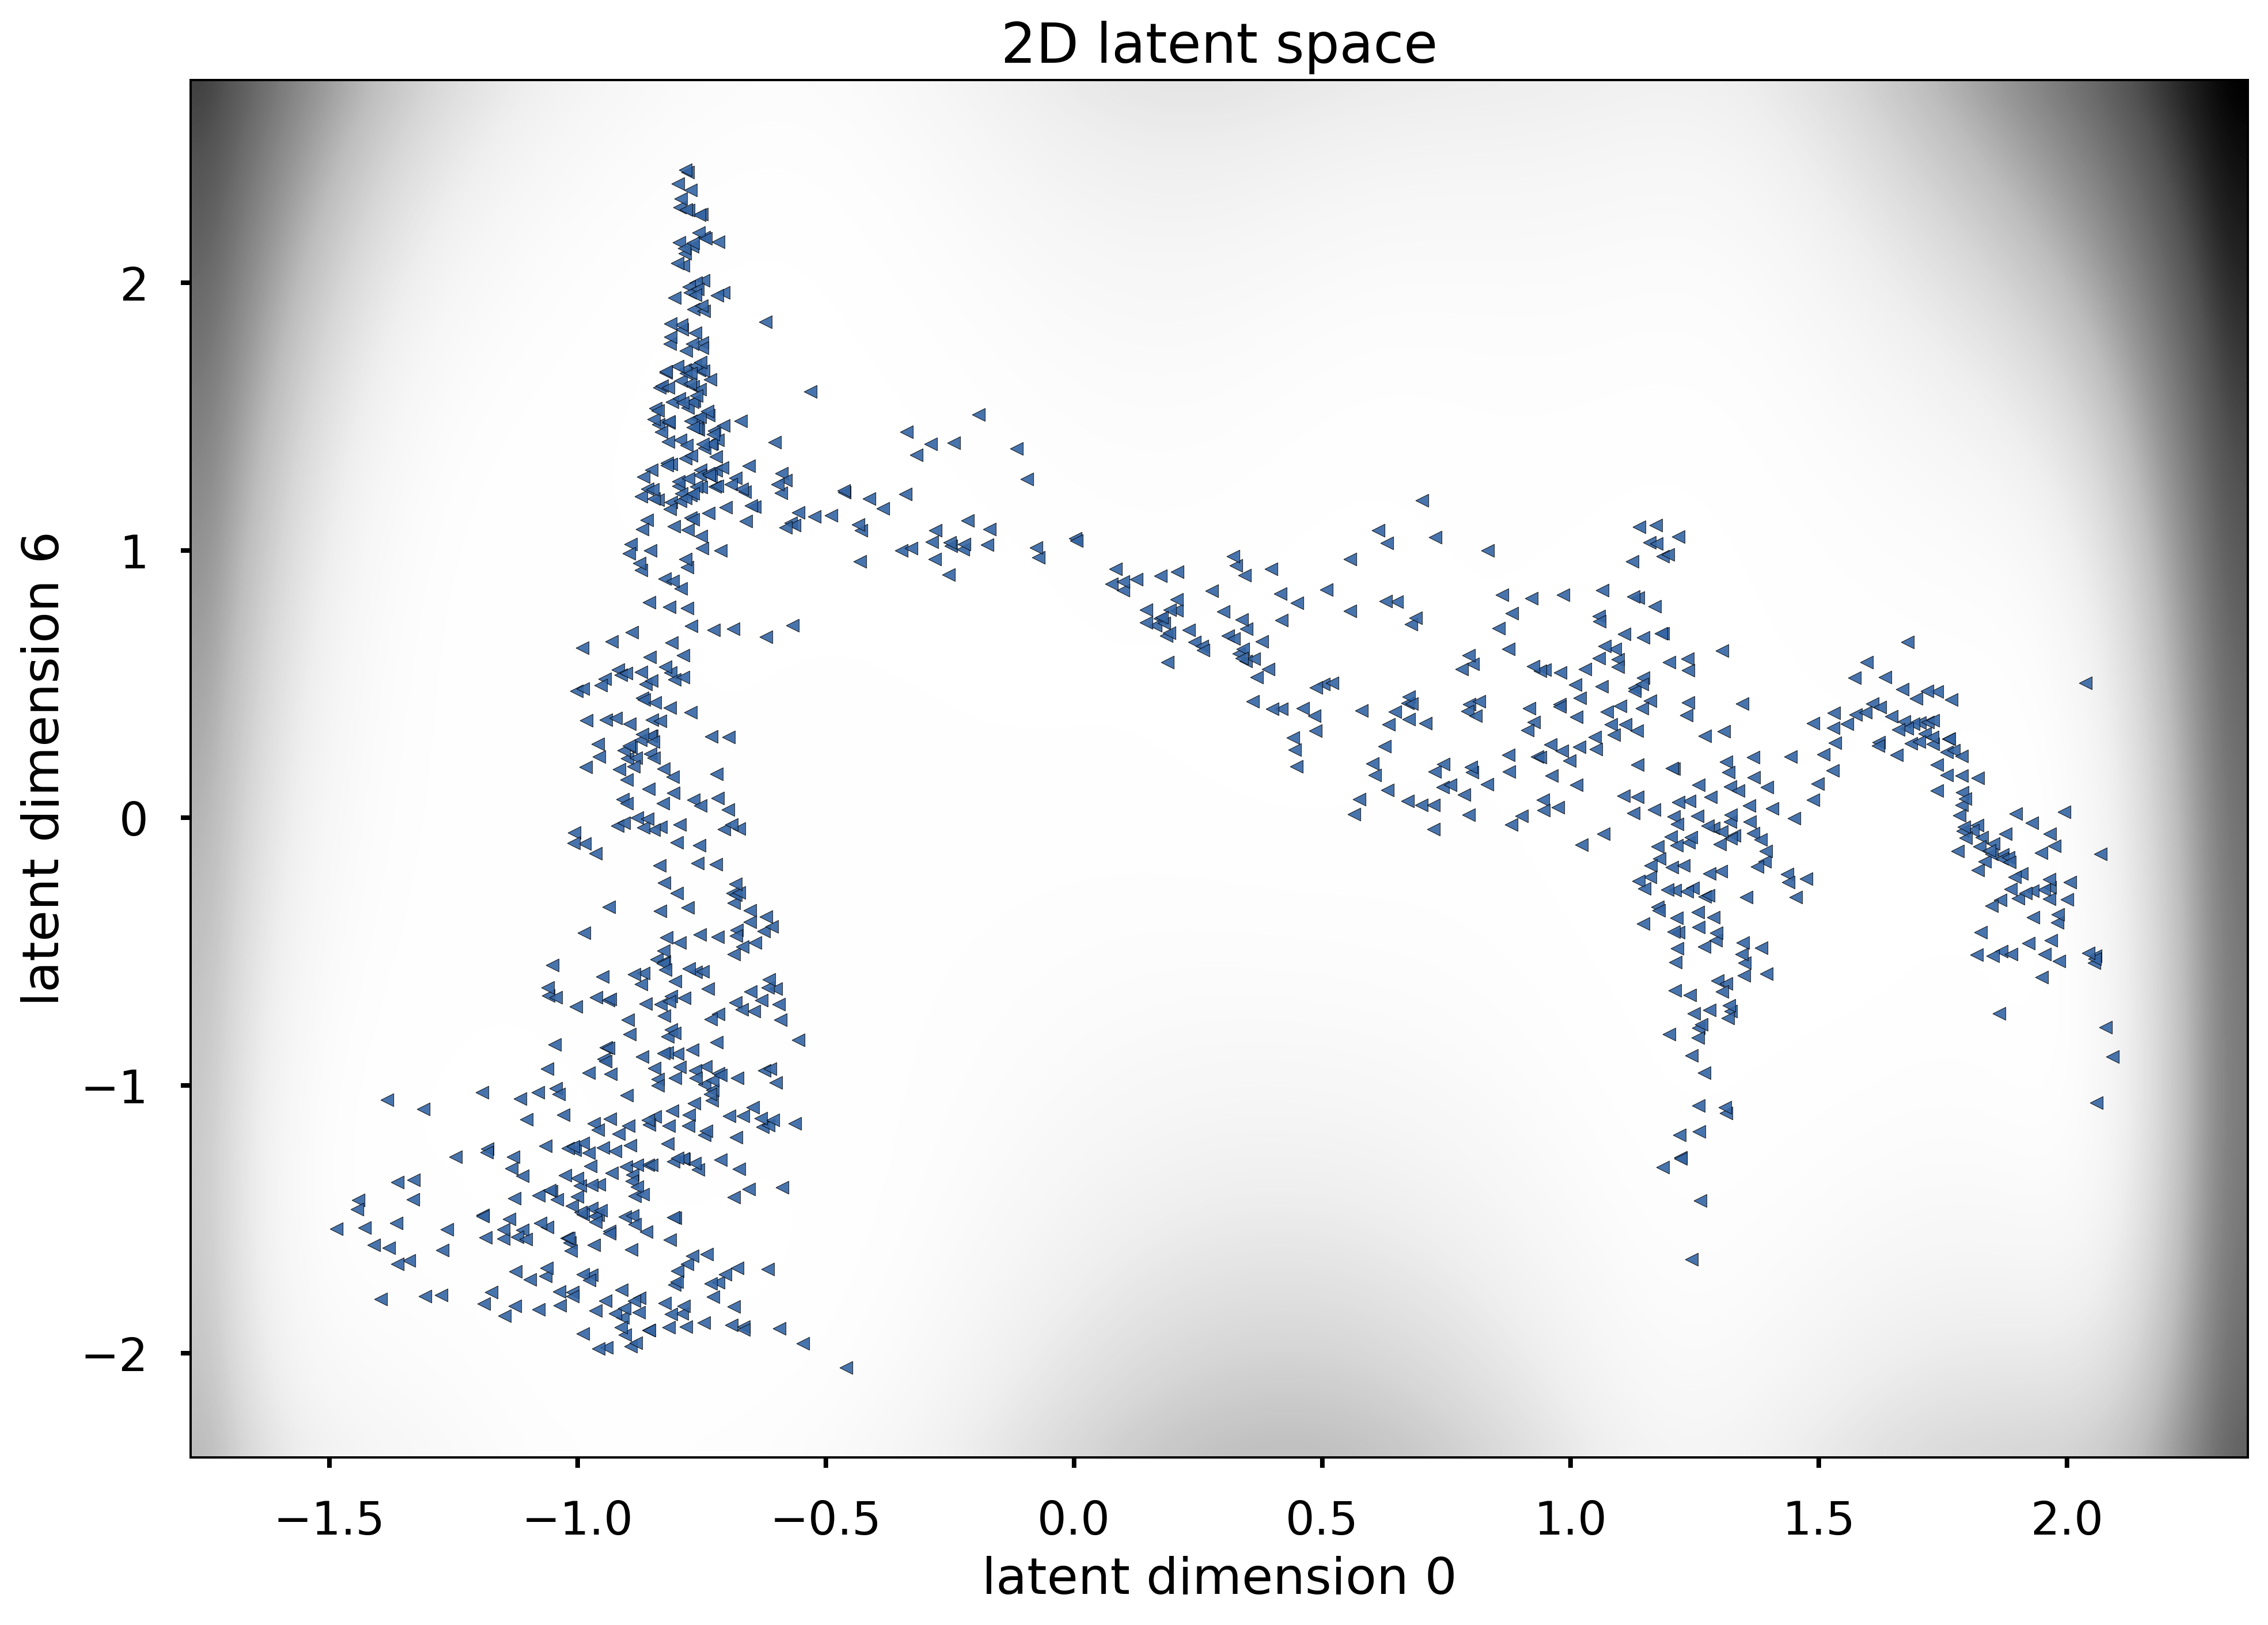

In [16]:
# m_GPLVM.plot_latent(updates=False, legend =True, resolution=100)

fig, ax = plt.subplots()
ax.set_title('2D latent space')
labels = Y
m_GPLVM.plot_latent(ax=ax, updates=False, legend =True)
filename = shape_name_string + ' 2D latent.png'
plt.savefig(filename)
files.download('/content/' + filename)

In [17]:
#use this to create an interactive 3D plot, use mouse buttons to translate, rotate and zoom
fig = go.Figure(data=[go.Scatter3d(x=latent[:, 2], y=latent[:,4], z=latent[:, 6],
                                   mode='markers',
                                   marker=dict(size=2, colorscale='Spectral',opacity=0.8)
                                   )])
fig.show()

In [18]:
plt.style.use('seaborn-poster')
ax = plt.axes(projection='3d')

ax.scatter3D(latent[:, input_dimension_1], latent[:,input_dimension_2], latent[:, input_dimension_3], c = latent[:, 2])
ax.set_title('3D latent space')

# Set axes label
ax.set_xlabel('input dimension ' + str(input_dimension_1), labelpad=20)
ax.set_ylabel('input dimension ' + str(input_dimension_2), labelpad=20)
ax.set_zlabel('input dimension ' + str(input_dimension_3), labelpad=20)

filename = shape_name_string + ' 3D latent.png'
plt.savefig(filename)
files.download('/content/' + filename)

plt.show(ax)



Output hidden; open in https://colab.research.google.com to view.

In [19]:
#Save/load the model

In [20]:
# 1: Saving a model:
filename = shape_name_string + ' BGPLVM.npy'
np.save(filename, m_GPLVM.param_array)
files.download('/content/' + filename)
print(m_GPLVM)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Name : bayesian gplvm
Objective : -4431.330879319365
Number of Parameters : 35359
Number of Optimization Parameters : 35359
Updates : True
Parameters:
  bayesian_gplvm.          |                  value  |  constraints  |  priors
  latent_space.mean        |              (2500, 7)  |               |        
  latent_space.variance    |              (2500, 7)  |      +ve      |        
  inducing_inputs          |                (50, 7)  |               |        
  rbf.variance             |      3.141080034743479  |      +ve      |        
  rbf.lengthscale          |                   (7,)  |      +ve      |        
  Gaussian_noise.variance  |  0.0009713400545138748  |      +ve      |        


In [21]:
# 2: loading a model
# Model creation, without initialization:
m_load = GPy.models.BayesianGPLVM(Y, input_dim, kernel=k_GPLVM, init=init, num_inducing=num_inducing, initialize=False)
m_load.update_model(False) # do not call the underlying expensive algebra on load
m_load.initialize_parameter() # Initialize the parameters (connect the parameters up)
m_load[:] = np.load(filename) # Load the parameters
m_load.update_model(True) # Call the algebra only once
print(m_load)


Name : bayesian gplvm
Objective : -4431.330879319365
Number of Parameters : 35359
Number of Optimization Parameters : 35359
Updates : True
Parameters:
  bayesian_gplvm.          |                  value  |  constraints  |  priors
  latent_space.mean        |              (2500, 7)  |               |        
  latent_space.variance    |              (2500, 7)  |      +ve      |        
  inducing_inputs          |                (50, 7)  |               |        
  rbf.variance             |      3.141080034743479  |      +ve      |        
  rbf.lengthscale          |                   (7,)  |      +ve      |        
  Gaussian_noise.variance  |  0.0009713400545138748  |      +ve      |        
